# Use pre-trained Model and get hidden representation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from SmilesTools import smiUtil as SU
from AE4SmilesLib import CNAE, tbHistoryPlot

Using TensorFlow backend.


In [2]:
sm = SU()

Keep parameters in dictionary  
**lrep** : hidden rep size  
**nEL** : number of conv + maxpool block  
**reg** : activity L1 regulation factor  
**flt** : number of conv filters per layer  
**opt** : optimizer to use  
**ngpu** : number of gpus to use   
**batch** : minibatch size  
**EPO** : number of epochs  

In [3]:
bp = {
    'lrep' : 145,
    'nEL' : 1,
    'reg' : 1.0e-9,
    'flt' : 32,
    'kern' : 5,
    'opt' : 'adam',
    'ngpu' : 1,
    'batch' : 256,
    'EPO' : 30
    }

bcn = CNAE(sm,**bp)

Network weights need to be created from net of same structure; **_lrep, nEL, flt & kern_** need to be same.

In [4]:
bcn.loadw('data/test5MCNNv3Co1.hdf5')

In [33]:
dat = pd.read_pickle('data/6MSmiles.pkl')

In [34]:
zinc10k = dat[-10000:]
zinc10k = zinc10k.reset_index(drop=True)

In [35]:
zinc10k.to_csv('data/zinc10k.csv',sep='\t')

In [6]:
k = 2000
zinctst = dat[-k:]
zinctst = zinctst.reset_index(drop=True)
del dat
zinctst.head()

,Molecule
0,O=C(Cn1nc(ccc1=O)-c1cccc2ccccc12)NC1CCCCCC1
1,COc1cc(cc(OC)c1OC)C(=O)NCCn1c(C)nc2ncccc2c1=O
2,Fc1cc(F)c(CC(=O)NCCCc2nnc3ccccn23)cc1F
3,Cc1nc2ccc(F)cc2c(=O)n1CC(=O)Nc1nc(cs1)-c1cccnc1
4,Clc1cccc(c1)N1CCN(CC1)C(=O)CCC(=O)NCc1cccnc1


In [7]:
zoh = sm.smi2OH(zinctst)

In [8]:
zhr = bcn.enc.predict(zoh)

In [9]:
zhr.shape

(2000, 145)

In [10]:
z0 = zhr[0]
z1 = zhr[1]

# Define Angular Cosine Similarity
Since hidden representation is generated via ReLu activation, all elements will be >=0, the factor 2.0 is needed.

In [11]:
def acsim(x1,x2):
    cs = np.dot(x1,x2)/np.sqrt(np.dot(x1,x1)*np.dot(x2,x2))
    return 1.0 - 2.0*np.arccos(cs)/np.pi

In [12]:
sim = [acsim(z0,z) for z in zhr]

In [13]:
prazosin = pd.DataFrame({'Molecule':'COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC'},index=[0])
prazosin

,Molecule
0,COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC


In [14]:
prz = sm.smi2OH(prazosin)

In [15]:
przq = bcn.enc.predict(prz)[0]

In [16]:
psim = [acsim(przq,z) for z in zhr]

In [17]:
zinctst['vsPrazosin']=psim

In [18]:
zinctst.head()

,Molecule,vsPrazosin
0,O=C(Cn1nc(ccc1=O)-c1cccc2ccccc12)NC1CCCCCC1,0.680152
1,COc1cc(cc(OC)c1OC)C(=O)NCCn1c(C)nc2ncccc2c1=O,0.702864
2,Fc1cc(F)c(CC(=O)NCCCc2nnc3ccccn23)cc1F,0.702455
3,Cc1nc2ccc(F)cc2c(=O)n1CC(=O)Nc1nc(cs1)-c1cccnc1,0.662192
4,Clc1cccc(c1)N1CCN(CC1)C(=O)CCC(=O)NCc1cccnc1,0.648110


In [19]:
cmpPairs = pd.read_csv('data/DM2000Pairs.csv',sep='\t')
cmpPairs.head()

,Cmpd1,Cmpd2,TS
0,*C(=O)OCC(COC(*)=O)OC(*)=O,*C(=O)OCC(COC(*)=O)OC(*)=O,1.000000
1,Oc1cc2cc([nH]c2cc1O)C([O-])=O,Oc1cc2cc([nH]c2cc1O)C([O-])=O,1.000000
2,CCCCCC(=O)CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(...,C[C@@H](O)CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(...,0.978998
3,Nc1ncnc2n(cnc12)[C@@H]1O[C@H](COP([O-])(=O)OS(...,Nc1ncnc2n(cnc12)[C@@H]1O[C@H](COP(O)(=O)OP(O)(...,0.965812
4,CCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP([O...,CCCCCCCC\C=C\CCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H...,0.952153


In [20]:
chkp = sm.filterGood(cmpPairs,'Cmpd1')

In [21]:
chkp = sm.filterGood(chkp,'Cmpd2')

In [22]:
chkp.head()

,Cmpd1,Cmpd2,TS
0,Oc1cc2cc([nH]c2cc1O)C([O-])=O,Oc1cc2cc([nH]c2cc1O)C([O-])=O,1.000000
1,CN(C)CCOc1ccc(cc1)C(=C(\CCCl)c1ccccc1)\c1ccccc1,OCCOc1ccc(cc1)C(=C(\CCCl)c1ccccc1)\c1ccccc1,0.938567
2,CC\C=C/C\C=C/C\C=C/C\C=C/C\C=C/CCCC(O)=O,CCCCCCCC\C=C\CCCCCCCC([O-])=O,0.924812
3,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@H](CC[C@]34C)OS...,C[C@H](CCC([O-])=O)[C@H]1CC[C@H]2[C@@H]3CC[C@@...,0.911290
4,CC\C=C/C\C=C/C\C=C/C\C=C/CCCCC(O)=O,OCCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(O)=O,0.897810


In [27]:
oh1 = sm.smi2OH(chkp,'Cmpd1')
h1 = bcn.enc.predict(oh1)
oh2 = sm.smi2OH(chkp,'Cmpd2')
h2 = bcn.enc.predict(oh2)
pairsim=[acsim(x,y) for x,y in zip(h1,h2)]

In [28]:
pairsim[0:10]

[1.0,
 0.6605820592597065,
 0.7028535308504846,
 0.7414143883381671,
 0.80399220205887,
 0.7558845804680361,
 0.7909701997605207,
 0.5093208037370903,
 0.6946727097175972,
 0.8359389699727799]

In [29]:
chkp['hsim'] = pairsim

In [30]:
chkp.head(20)

,Cmpd1,Cmpd2,TS,hsim
0,Oc1cc2cc([nH]c2cc1O)C([O-])=O,Oc1cc2cc([nH]c2cc1O)C([O-])=O,1.000000,1.000000
1,CN(C)CCOc1ccc(cc1)C(=C(\CCCl)c1ccccc1)\c1ccccc1,OCCOc1ccc(cc1)C(=C(\CCCl)c1ccccc1)\c1ccccc1,0.938567,0.660582
2,CC\C=C/C\C=C/C\C=C/C\C=C/C\C=C/CCCC(O)=O,CCCCCCCC\C=C\CCCCCCCC([O-])=O,0.924812,0.702854
3,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@H](CC[C@]34C)OS...,C[C@H](CCC([O-])=O)[C@H]1CC[C@H]2[C@@H]3CC[C@@...,0.911290,0.741414
4,CC\C=C/C\C=C/C\C=C/C\C=C/CCCCC(O)=O,OCCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(O)=O,0.897810,0.803992
5,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,C[C@@H]1C[C@@]2(C)[C@@H](CC[C@H]3[C@@H]4CC[C@H...,0.885481,0.755885
6,CC(=O)OCC(=O)[C@@]12OC(C)(C)O[C@@H]1C[C@H]1[C@...,C[C@H]1C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@]...,0.875723,0.790970
7,CCCCC\C=C/C\C=C/CCCCCCCC(=O)O[C@H]1CC[C@]2(C)[...,CCOC(=O)OC1(CCC2C3CCC4=CC(=O)C=CC4(C)C3C(O)CC1...,0.851171,0.509321
8,CC(C(O)=O)c1cccc(c1)C(=O)c1ccccc1,CCN(CC)CCOC(=O)C1(CCCCC1)C1CCCCC1,0.844697,0.694673
9,CCCCC\C=C/C\C=C/CCCCCCCC(=O)O[C@H]1CC[C@]2(C)[...,C[C@H](CCC(=O)NCCS([O-])(=O)=O)[C@H]1CC[C@H]2[...,0.832765,0.835939


In [37]:
p = np.polyfit(chkp.TS,chkp.hsim,deg=1)
x = chkp.TS
y = p[1] + p[0]*x

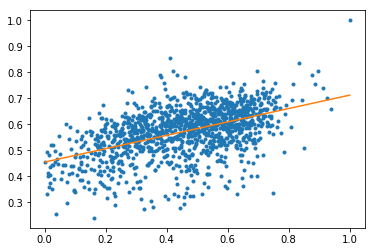

In [38]:
plt.plot(chkp.TS,chkp.hsim,'.')
plt.plot(x,y)

In [39]:
import seaborn as sns

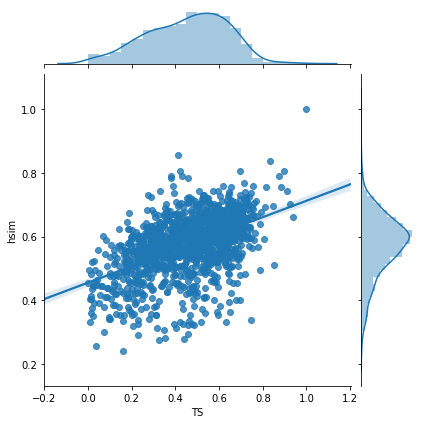

In [47]:
x,y = chkp.TS,chkp.hsim
sns.jointplot(x,y,kind='reg')

In [48]:
zincPairs = pd.read_csv('data/Zinc2000Pairs.csv',sep='\t')
zincPairs.head()

,Cmpd1,Cmpd2,TS
0,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,1.000000
1,COc1ccc(cc1)S(=O)(=O)NCc1ccc(cc1)C(=O)Nc1cccc2...,CC(=O)Nc1ccc(cc1)S(=O)(=O)N1CCC(CC1)C(=O)Nc1cc...,0.890591
2,Cc1cc(N)nc(SC[C@H]2Cn3c(S2)nnc3-c2cccnc2)n1,C(Sc1ccccc1)[C@H]1Cn2c(S1)nnc2-c1cccnc1,0.864322
3,CC[C@@H](Oc1cccc(C)c1)C(=O)NCc1ccc(OC2CC[NH+](...,[O-]C(=O)[C@@H](Cc1ccccc1)NC(=O)c1cccc(OCc2ccc...,0.851515
4,Fc1cc(ccc1C(=O)N1CCCC1)S(=O)(=O)N(CC#C)CC#C,CC[C@H]1CC[C@H](C)N1C(=O)c1cccc([N-]S(=O)(=O)c...,0.842893


In [49]:
oh1 = sm.smi2OH(zincPairs,'Cmpd1')
h1 = bcn.enc.predict(oh1)
oh2 = sm.smi2OH(zincPairs,'Cmpd2')
h2 = bcn.enc.predict(oh2)
zpairsim=[acsim(x,y) for x,y in zip(h1,h2)]

In [50]:
zincPairs['hsim']=zpairsim; zincPairs.head()

,Cmpd1,Cmpd2,TS,hsim
0,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,1.000000,1.000000
1,COc1ccc(cc1)S(=O)(=O)NCc1ccc(cc1)C(=O)Nc1cccc2...,CC(=O)Nc1ccc(cc1)S(=O)(=O)N1CCC(CC1)C(=O)Nc1cc...,0.890591,0.665630
2,Cc1cc(N)nc(SC[C@H]2Cn3c(S2)nnc3-c2cccnc2)n1,C(Sc1ccccc1)[C@H]1Cn2c(S1)nnc2-c1cccnc1,0.864322,0.708147
3,CC[C@@H](Oc1cccc(C)c1)C(=O)NCc1ccc(OC2CC[NH+](...,[O-]C(=O)[C@@H](Cc1ccccc1)NC(=O)c1cccc(OCc2ccc...,0.851515,0.607633
4,Fc1cc(ccc1C(=O)N1CCCC1)S(=O)(=O)N(CC#C)CC#C,CC[C@H]1CC[C@H](C)N1C(=O)c1cccc([N-]S(=O)(=O)c...,0.842893,0.617549


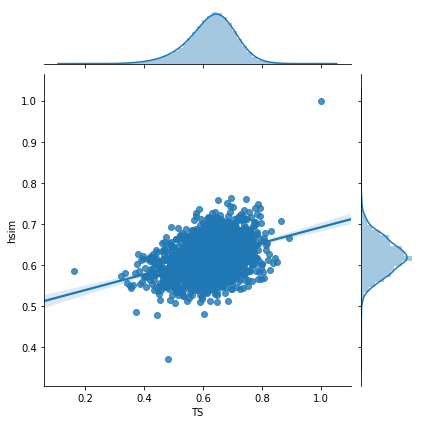

In [52]:
sns.jointplot('TS','hsim',data=zincPairs,kind='reg')

In [64]:
dfh1=pd.DataFrame(h1)
dfh1.columns = ['H'+str(c) for c in dfh1.columns]
dfh1.head()

,H0,H1,H2,H3,H4,H5,H6,H7,H8,H9,...,H135,H136,H137,H138,H139,H140,H141,H142,H143,H144
0,0.0,0.099204,0.0,0.0,0.0,0.0,0.097722,0.219863,0.123816,0.353712,...,0.0,0.227756,0.628290,0.217114,0.0,0.0,0.150730,0.0,0.0,0.226072
1,0.0,0.088266,0.0,0.0,0.0,0.0,0.295449,0.338503,0.345947,0.418717,...,0.0,0.596846,0.749661,0.109194,0.0,0.0,0.186082,0.0,0.0,0.333012
2,0.0,0.395645,0.0,0.0,0.0,0.0,0.396324,0.231553,0.427909,0.564698,...,0.0,0.562633,0.464882,0.471835,0.0,0.0,0.375649,0.0,0.0,0.187534
3,0.0,0.515022,0.0,0.0,0.0,0.0,0.383243,0.374301,0.447992,0.164514,...,0.0,1.087228,0.379912,0.171713,0.0,0.0,0.222431,0.0,0.0,0.666640
4,0.0,0.491633,0.0,0.0,0.0,0.0,0.217804,0.217975,0.347676,0.202361,...,0.0,0.556289,0.407643,0.201308,0.0,0.0,0.241586,0.0,0.0,0.323353


In [65]:
dfzh1 = pd.concat([zincPairs,dfh1],axis=1); dfzh1.head()

,Cmpd1,Cmpd2,TS,hsim,H0,H1,H2,H3,H4,H5,...,H135,H136,H137,H138,H139,H140,H141,H142,H143,H144
0,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,1.000000,1.000000,0.0,0.099204,0.0,0.0,0.0,0.0,...,0.0,0.227756,0.628290,0.217114,0.0,0.0,0.150730,0.0,0.0,0.226072
1,COc1ccc(cc1)S(=O)(=O)NCc1ccc(cc1)C(=O)Nc1cccc2...,CC(=O)Nc1ccc(cc1)S(=O)(=O)N1CCC(CC1)C(=O)Nc1cc...,0.890591,0.665630,0.0,0.088266,0.0,0.0,0.0,0.0,...,0.0,0.596846,0.749661,0.109194,0.0,0.0,0.186082,0.0,0.0,0.333012
2,Cc1cc(N)nc(SC[C@H]2Cn3c(S2)nnc3-c2cccnc2)n1,C(Sc1ccccc1)[C@H]1Cn2c(S1)nnc2-c1cccnc1,0.864322,0.708147,0.0,0.395645,0.0,0.0,0.0,0.0,...,0.0,0.562633,0.464882,0.471835,0.0,0.0,0.375649,0.0,0.0,0.187534
3,CC[C@@H](Oc1cccc(C)c1)C(=O)NCc1ccc(OC2CC[NH+](...,[O-]C(=O)[C@@H](Cc1ccccc1)NC(=O)c1cccc(OCc2ccc...,0.851515,0.607633,0.0,0.515022,0.0,0.0,0.0,0.0,...,0.0,1.087228,0.379912,0.171713,0.0,0.0,0.222431,0.0,0.0,0.666640
4,Fc1cc(ccc1C(=O)N1CCCC1)S(=O)(=O)N(CC#C)CC#C,CC[C@H]1CC[C@H](C)N1C(=O)c1cccc([N-]S(=O)(=O)c...,0.842893,0.617549,0.0,0.491633,0.0,0.0,0.0,0.0,...,0.0,0.556289,0.407643,0.201308,0.0,0.0,0.241586,0.0,0.0,0.323353


In [66]:
dfzh1.drop(columns=['Cmpd2','TS','hsim'],inplace=True); dfzh1.head()

,Cmpd1,H0,H1,H2,H3,H4,H5,H6,H7,H8,...,H135,H136,H137,H138,H139,H140,H141,H142,H143,H144
0,Brc1cc(co1)C(=O)N1CC=C(C1)c1ccccc1,0.0,0.099204,0.0,0.0,0.0,0.0,0.097722,0.219863,0.123816,...,0.0,0.227756,0.628290,0.217114,0.0,0.0,0.150730,0.0,0.0,0.226072
1,COc1ccc(cc1)S(=O)(=O)NCc1ccc(cc1)C(=O)Nc1cccc2...,0.0,0.088266,0.0,0.0,0.0,0.0,0.295449,0.338503,0.345947,...,0.0,0.596846,0.749661,0.109194,0.0,0.0,0.186082,0.0,0.0,0.333012
2,Cc1cc(N)nc(SC[C@H]2Cn3c(S2)nnc3-c2cccnc2)n1,0.0,0.395645,0.0,0.0,0.0,0.0,0.396324,0.231553,0.427909,...,0.0,0.562633,0.464882,0.471835,0.0,0.0,0.375649,0.0,0.0,0.187534
3,CC[C@@H](Oc1cccc(C)c1)C(=O)NCc1ccc(OC2CC[NH+](...,0.0,0.515022,0.0,0.0,0.0,0.0,0.383243,0.374301,0.447992,...,0.0,1.087228,0.379912,0.171713,0.0,0.0,0.222431,0.0,0.0,0.666640
4,Fc1cc(ccc1C(=O)N1CCCC1)S(=O)(=O)N(CC#C)CC#C,0.0,0.491633,0.0,0.0,0.0,0.0,0.217804,0.217975,0.347676,...,0.0,0.556289,0.407643,0.201308,0.0,0.0,0.241586,0.0,0.0,0.323353


In [67]:
dfzh1.to_csv('data/zincH1.csv',sep='\t')